In [1]:
from memflow.read_data.dataset_all import DatasetCombined
from memflow.unfolding_network.conditional_transformer import ConditioningTransformerLayer
from memflow.unfolding_flow.utils import *

import numpy as np
import scipy.stats as st
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import normalize
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
from matplotlib import cm

from tensorboardX import SummaryWriter
from omegaconf import OmegaConf
import sys
import argparse
import os
from pynvml import *
from hist import Hist
import hist
import vector
import mplhep
import awkward as ak

from memflow.read_data.utils import to_flat_tensor
from memflow.phasespace.phasespace import PhaseSpace
import memflow.phasespace.utils as utils 

from utils import FindMasks
from utils import SavePlots

pi = torch.pi

import itertools

In [2]:
path_data = '../../dataset/v7/all_jets_fullRun2_v1.parquet'
device = torch.device('cpu')
data = DatasetCombined(path_data, dev=device, dtype=torch.float64,
                        reco_list=['data_boost'],
                        parton_list=['data_higgs_t_tbar_ISR',
                                     'data_higgs_t_tbar_ISR_cartesian',
                                    'phasespace_intermediateParticles',
                                    'phasespace_rambo_detjacobian',
                                    'phasespace_intermediateParticles_onShell'])


RecoLevel
Reading reco_level Files

PartonLevel
Reading parton_level Files
Load phasespace_intermediateParticles
Load phasespace_intermediateParticles_onShell
Load phasespace_rambo_detjacobian



In [4]:
data_higgs_t_tbar_ISR_cartesian = data.parton_data.data_higgs_t_tbar_ISR_cartesian
data_boost_reco = data.reco_data.data_boost
data_phasespace = data.parton_data.phasespace_intermediateParticles
data_boost_partons = data.parton_data.data_boost
print(data_higgs_t_tbar_ISR_cartesian[0,2])

data_PS_onShell = data.parton_data.phasespace_intermediateParticles_onShell

tensor([203.2750,   2.1877, -40.1099,  99.0270])


In [5]:
mask = data_phasespace < 0
#print(mask)
mask_row = torch.any(mask, dim=1)
print(mask_row)
indices_ev = mask_row.nonzero()
indices_ev = indices_ev.squeeze(dim=1)
print(indices_ev)

tensor([False, False, False,  ..., False, False, False])
tensor([  37030,   66388,   92040,  152292,  192586,  197057,  206164,  226363,
         296063,  302165,  370647,  393590,  412417,  479968,  552836,  601969,
         617719,  650753,  795840,  796784,  818128,  869079,  920723, 1080593,
        1130218, 1142611, 1164522, 1198023, 1245152, 1333970, 1336359, 1351273,
        1374953, 1388298, 1399500])


In [7]:
mask = data_PS_onShell < 0
mask2 = data_PS_onShell > 1
print(mask.count_nonzero())
print(mask2.count_nonzero())

tensor(0)
tensor(0)


In [22]:
data_higgs_t_tbar_ISR_cartesian_onshell = data_higgs_t_tbar_ISR_cartesian.clone()
M_HIGGS = 125.25
M_TOP = 172.5
M = torch.Tensor([M_HIGGS, M_TOP, M_TOP, 0.00001])
data_higgs_t_tbar_ISR_cartesian_onshell[:,:,0] = torch.sqrt(data_higgs_t_tbar_ISR_cartesian[:,:,1]**2 + data_higgs_t_tbar_ISR_cartesian[:,:,2]**2 + data_higgs_t_tbar_ISR_cartesian[:,:,3]**2 + M**2)

In [24]:
ev = 37030 # bad event

momenta = data_higgs_t_tbar_ISR_cartesian[ev].unsqueeze(dim=0)

momenta_on_shell = data_higgs_t_tbar_ISR_cartesian_onshell[ev].unsqueeze(dim=0)

print(momenta)
print('momenta MC\n')
print(momenta_on_shell)
print('momenta on shell')

def get_mass(tensor):
    mass_tensor = torch.zeros((tensor.shape[0], 4))
    for i in range(4):
        mass_tensor[:,i] = torch.sqrt(tensor[:,i,0]**2 - tensor[:,i,1]**2 - tensor[:,i,2]**2 - tensor[:,i,3]**2)
    return mass_tensor

mass_tensor_onshell = get_mass(momenta_on_shell)
print(mass_tensor_onshell)
print('mass MC\n')

mass_tensor = get_mass(momenta)
print(mass_tensor)
print('mass on shell\n')

tensor([[[168.7829, -55.9937, -98.5694,  -3.3839],
         [179.5373,  48.0889,  59.0224, -13.1790],
         [179.9598,   9.0035,  46.0696,  16.3079],
         [  6.6195,  -1.1066,  -6.5210,   0.2637]]])
momenta MC

tensor([[[168.9682, -55.9937, -98.5694,  -3.3839],
         [189.0135,  48.0889,  59.0224, -13.1790],
         [179.5151,   9.0035,  46.0696,  16.3079],
         [  6.6195,  -1.1066,  -6.5210,   0.2637]]])
momenta on shell
tensor([[1.2525e+02, 1.7250e+02, 1.7250e+02, 9.9997e-06]])
mass MC

tensor([[1.2500e+02, 1.6206e+02, 1.7296e+02, 5.5050e-05]])
mass on shell



In [25]:
order = [0,1,2,3]
print('PS target')

PS, detjinv = Compute_ParticlesTensor.get_PS(momenta, data_boost_partons[0], order=order)
print('')

print('PS on shell')
PS_onshell, detjinv = Compute_ParticlesTensor.get_PS(momenta_on_shell, data_boost_partons[0], order=order)
print('\n\n')

print(f'PS: {PS}\n')
print(f'PS_onshell: {PS_onshell}\n')

PS target
torch.Size([1, 4])
tensor([[125.2500, 172.5000, 172.5000,   0.0000]])
----------------------------------------------------------------------


PS on shell
torch.Size([1, 4])
tensor([[125.2500, 172.5000, 172.5000,   0.0000]])
----------------------------------------------------------------------




PS: tensor([[ 1.6003e-05, -5.1183e+01,  4.8507e-01,  6.6778e-01,  2.3792e-01,
          7.9591e-02,  5.2460e-01,  2.2233e-01,  1.3893e-01,  1.4740e-02]])

PS_onshell: tensor([[0.0025, 0.6983, 0.4851, 0.6678, 0.2260, 0.0735, 0.5247, 0.2223, 0.1389,
         0.0147]])



In [26]:
order = [0,1,2,3]
print('PS target')

PS, detjinv = Compute_ParticlesTensor.get_PS(momenta, data_boost_partons[0],
                                             order=order, target_mass=get_mass(momenta))
print('')

print('PS on shell')
PS_onshell, detjinv = Compute_ParticlesTensor.get_PS(momenta_on_shell, data_boost_partons[0],
                                                     order=order, target_mass=get_mass(momenta_on_shell))
print('\n\n')

print(f'PS: {PS}\n')
print(f'PS_onshell: {PS_onshell}\n')

PS target
torch.Size([1, 4])
tensor([[1.2500e+02, 1.6206e+02, 1.7296e+02, 5.5050e-05]])
----------------------------------------------------------------------


PS on shell
torch.Size([1, 4])
tensor([[1.2525e+02, 1.7250e+02, 1.7250e+02, 9.9997e-06]])
----------------------------------------------------------------------




PS: tensor([[0.0027, 0.6603, 0.4851, 0.6678, 0.2379, 0.0796, 0.5246, 0.2223, 0.1389,
         0.0147]])

PS_onshell: tensor([[0.0025, 0.6983, 0.4851, 0.6678, 0.2260, 0.0735, 0.5247, 0.2223, 0.1389,
         0.0147]])



In [27]:
try1 = torch.tensor([[125.25, 172.5, 172.5, 0.0]])
print('PS1')
PS1, detjinv = Compute_ParticlesTensor.get_PS(momenta_on_shell, data_boost_partons[0], order=order,
                                              target_mass=try1)

print('PS2')
PS2, detjinv = Compute_ParticlesTensor.get_PS(momenta_on_shell, data_boost_partons[0], order=order)
print('\n\n')

print(PS1)
print(PS2)


PS1
torch.Size([1, 4])
tensor([[125.2500, 172.5000, 172.5000,   0.0000]])
----------------------------------------------------------------------

PS2
torch.Size([1, 4])
tensor([[125.2500, 172.5000, 172.5000,   0.0000]])
----------------------------------------------------------------------




tensor([[0.0025, 0.6983, 0.4851, 0.6678, 0.2260, 0.0735, 0.5247, 0.2223, 0.1389,
         0.0147]])
tensor([[0.0025, 0.6983, 0.4851, 0.6678, 0.2260, 0.0735, 0.5247, 0.2223, 0.1389,
         0.0147]])


In [28]:
permutations = list(itertools.permutations([0, 1, 2, 3]))

for i in range(len(permutations)):
    order = list(permutations[i])
    PS, detjinv = Compute_ParticlesTensor.get_PS(data_higgs_t_tbar_ISR_cartesian,
                                             data_boost_partons, order=order,
                                                target_mass=get_mass(data_higgs_t_tbar_ISR_cartesian))
    print(order)
    mask = PS < 0
    print(mask.count_nonzero())
    mask2 = PS > 1
    print(mask2.count_nonzero())
    print('')
    
print('Finish')

torch.Size([1414130, 4])
tensor([[1.2500e+02, 1.7194e+02, 1.7292e+02, 3.3000e-01],
        [1.2500e+02, 1.6537e+02, 1.7283e+02,        nan],
        [1.2500e+02, 1.7245e+02, 1.7074e+02, 4.0751e-03],
        ...,
        [1.2523e+02, 1.7187e+02, 1.7243e+02,        nan],
        [1.2500e+02, 1.7223e+02, 1.7337e+02, 8.0220e-04],
        [1.2500e+02, 1.7265e+02, 1.7267e+02, 3.2956e-01]])
----------------------------------------------------------------------

[0, 1, 2, 3]
tensor(0)
tensor(0)

torch.Size([1414130, 4])
tensor([[1.2500e+02, 1.7194e+02, 1.7292e+02, 3.3000e-01],
        [1.2500e+02, 1.6537e+02, 1.7283e+02,        nan],
        [1.2500e+02, 1.7245e+02, 1.7074e+02, 4.0751e-03],
        ...,
        [1.2523e+02, 1.7187e+02, 1.7243e+02,        nan],
        [1.2500e+02, 1.7223e+02, 1.7337e+02, 8.0220e-04],
        [1.2500e+02, 1.7265e+02, 1.7267e+02, 3.2956e-01]])
----------------------------------------------------------------------

[0, 1, 3, 2]
tensor(0)
tensor(0)

torch.Size([14

----------------------------------------------------------------------

[2, 3, 0, 1]
tensor(0)
tensor(0)

torch.Size([1414130, 4])
tensor([[1.2500e+02, 1.7194e+02, 1.7292e+02, 3.3000e-01],
        [1.2500e+02, 1.6537e+02, 1.7283e+02,        nan],
        [1.2500e+02, 1.7245e+02, 1.7074e+02, 4.0751e-03],
        ...,
        [1.2523e+02, 1.7187e+02, 1.7243e+02,        nan],
        [1.2500e+02, 1.7223e+02, 1.7337e+02, 8.0220e-04],
        [1.2500e+02, 1.7265e+02, 1.7267e+02, 3.2956e-01]])
----------------------------------------------------------------------

[2, 3, 1, 0]
tensor(0)
tensor(0)

torch.Size([1414130, 4])
tensor([[1.2500e+02, 1.7194e+02, 1.7292e+02, 3.3000e-01],
        [1.2500e+02, 1.6537e+02, 1.7283e+02,        nan],
        [1.2500e+02, 1.7245e+02, 1.7074e+02, 4.0751e-03],
        ...,
        [1.2523e+02, 1.7187e+02, 1.7243e+02,        nan],
        [1.2500e+02, 1.7223e+02, 1.7337e+02, 8.0220e-04],
        [1.2500e+02, 1.7265e+02, 1.7267e+02, 3.2956e-01]])
--------------

In [6]:
def check_mass(tensor, particle):
    mass = torch.sqrt(tensor[:,particle,0]**2 - tensor[:,particle,1]**2 - tensor[:,particle,2]**2 - tensor[:,particle,3]**2)
    plt.hist(mass.detach().numpy(), bins=10)
    plt.show()

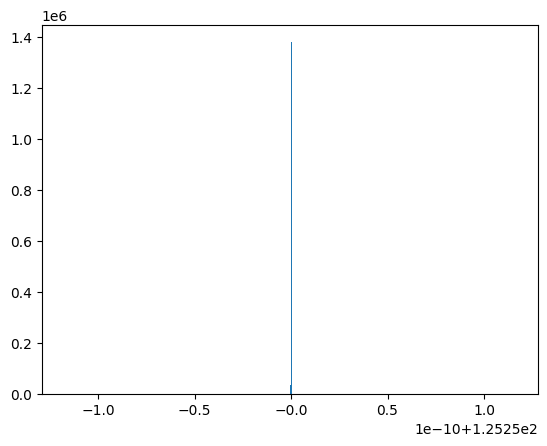

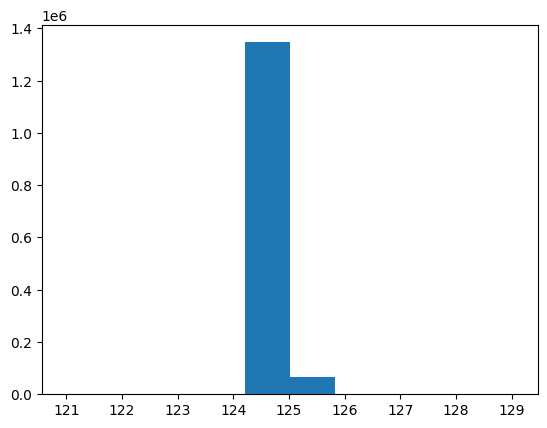

In [7]:
check_mass(data_higgs_t_tbar_ISR_cartesian_onshell, particle=0)
check_mass(data_higgs_t_tbar_ISR_cartesian, particle=0)

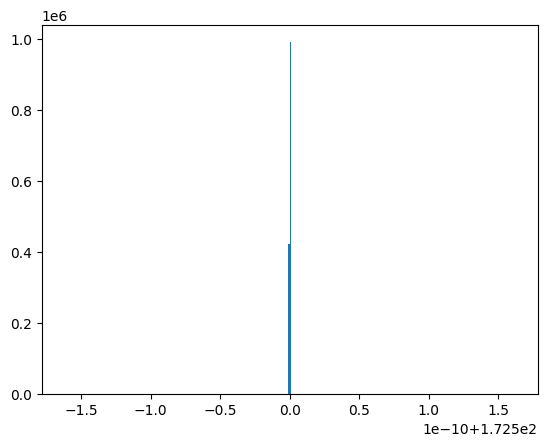

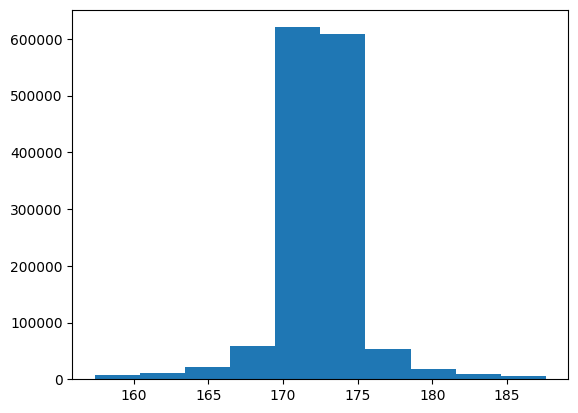

In [8]:
check_mass(data_higgs_t_tbar_ISR_cartesian_onshell, particle=1)
check_mass(data_higgs_t_tbar_ISR_cartesian, particle=1)

In [16]:
phasespace = PhaseSpace(collider_energy=13000, initial_pdgs=[21, 21], final_pdgs=[25, 6, -6, 21], dev="cpu")

def check_diff(tensor1, tensor2, boost):
    PS1, detjinv = Compute_ParticlesTensor.get_PS(tensor1, boost)
    PS2, detjinv = Compute_ParticlesTensor.get_PS(tensor2, boost)
    
    f, axs = plt.subplots(10, 2, figsize=(6,3))
    
    for i in range(10):
        ax = axs[i]
        ax[0].hist(PS1[:,i].numpy(), bins=100)
        ax[1].hist(PS2[:,i].numpy(), bins=100)
        ax[0].set_xlabel(f"PS {i}")
        ax[1].set_xlabel(f"PS {i}")
    plt.tight_layout()


In [17]:
print(data_boost_partons)

tensor([[[ 998.8601,    0.0000,    0.0000,  807.2465]],

        [[2170.4863,    0.0000,    0.0000, 1982.0712]],

        [[1156.0483,    0.0000,    0.0000, -876.8878]],

        ...,

        [[1614.9950,    0.0000,    0.0000, 1182.3378]],

        [[1807.4021,    0.0000,    0.0000, 1455.2932]],

        [[2783.1497,    0.0000,    0.0000, 1771.2937]]])


/tmp/ipykernel_68421/2743725967.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


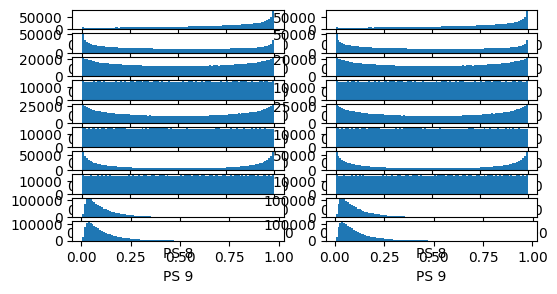

In [18]:
check_diff(data_higgs_t_tbar_ISR_cartesian_onshell, data_higgs_t_tbar_ISR_cartesian_onshell, data_boost_partons)